# ML Assignment 2


##  Team Members

-  Aitazaz  Ali,  s4004062

## 1. Introduction

- **Bullet Points Overview:**
  - **Goal:** Build predictive models for classifying histopathelogy images of collon cells:
    - *cellType*: need to classify type of cell.
    - *isCancerous*: need to classify if cell is a cancerous cell.

---

## 2. Exploratory Data Analysis (EDA)

# Handling Imbalanced Data

### Cancerous vs Not Cancerous

- It is **Imbalanced**: There are approximately 6,000 *not cancerous* examples versus approximately 4,000 *cancerous* examples (See Figure 1).
- If the model **guesses** (without learning) *not cancerous* 60% of the time, it would achieve 60% accuracy on the training set.
- Therefore, **performance metrics must be robust**, such as using the **F1-Score**.
- The model could **overfit** to predicting *not cancerous*.
  - To prevent this, ensure that **train, validation, and test sets** have a valid distribution of both classes.
  - This ensures that **overfitting is detected** when poor predictions are reflected in performance metrics.

## Cell Type Classification

- Cell type also **Imbalanced** (See Figure 2):
  - Type 2: ~4,000 examples
  - Type 1: ~2,500 examples
  - Type 0: ~2,000 examples
  - Type 3: ~1,500 examples
- If the model **guesses** Type 2 cells 40% of the time (without learning patterns), it would achieve 40% accuracy.
- The model may not learn **characteristic patterns** for each cell type equally.
  - Learning patterns for just Type 1 and Type 2 could lead to ~65% accuracy.

## Other Insights Into Potential Issues



- There is no null values in any column of dataset.
- See figure 9, 10, 11 for some example images of each cellType
    - None suffer from embedded text issues
    - Given it is a 27x27 image and We are still able to decipher the shapes of the cells. It does not seem suffer from problematic blur.   

## Addressing Class Imbalance

- Use robust performance metrics (F1-Score) and validation techniques to reduce the effects of class imbalance.
- **Cross-validation** can provide a more robust estimate of model performance by evaluating across multiple data subsets.
  - Helps expose the model to different training set distributions.
- **Augmentation** can help balance class distributions.
- Aim to construct batches that equally represent all classes.
  - But this can be difficult to implement effectively.

---
## 2. Data Splitting and Approach

## Data Splitting Strategy

- The ~9000 images are from 60 patients (main dataset). Each patient has different count of cellTypes (See Figure 4, 5, 6, 7). But only the epithelial cells show cancerous status in the main set. (See Figure 3)  
  - There is ~4000 cancerous cell types, all are epithelial cells but not all patients have epithelial cells. (See Figure 3)

- **What we will do**
  - We split the examples based on patientID
  - We divide patients into three groups: test, validation and train 
      - Each group will have relatively same amount cancerous vs non-cancerous as is present in the whole dataset. (~40% ) 
        - This ensures each group is a good representative of the whole dataset. 
      - Each group will also have relatively same amount of each cellType as is representative of the whole dataset. 
        - Therefore, need to ensure patients grouped for each split can provide sufficient images of each cellType.  
    - This could cause high variance as the train split is not good representative 
    - This could cause high bias as the model starts to guess/make assumptions about the patterns instead of learning. 

---
## 3. Preprocessing

## Data Handling Methods

-  We have 9896 pictures. However, there is class imbalance. Could augment existing images for certain class types to get balanced classes. 
-  We can use **normalisation**. Helps model learn patterns. Each pixel of image is a feature. The network learns how important each feature is.  Normalising helps the network fairly evaluate how important each pixel really is.  Otherwise, they might over prioritise pixels with higher values in the learning process. 
-  **Data Augmentation** to help data imbalance by creating more examples of miniority classes. 

---


In [4]:
# import zipfile
# with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
#     zip.ref.extractall('./')

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

data = pd.read_csv('./Image_classification_data/data_labels_mainData.csv')
data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB
None


Check if any nulls 
InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64


Summary data statistics 
         InstanceID    patientID     cellType  isCancerous
count   9896.000000  9896.000000  9896.000000  9896.000000
mean   10193.880154    29.762025     1.501516     0.412187
std     6652.912660    17.486553     0.954867     0.492253
min        1.000000     1.000000     0.000000     0.000000
25%     4135.750000    14.000000    

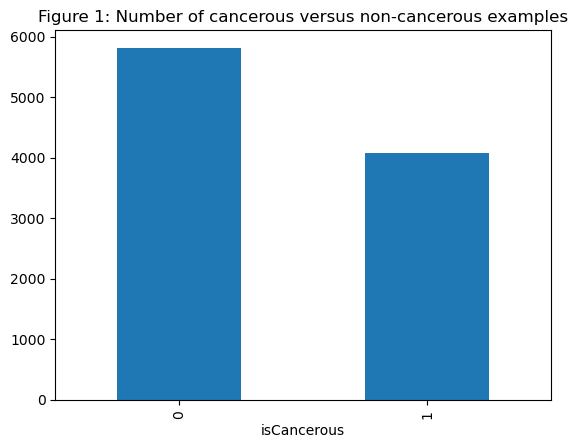

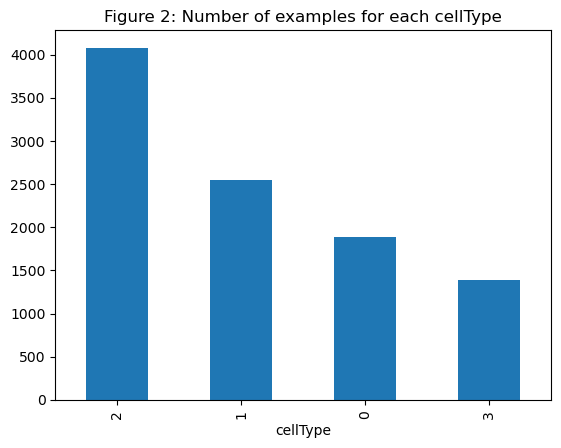

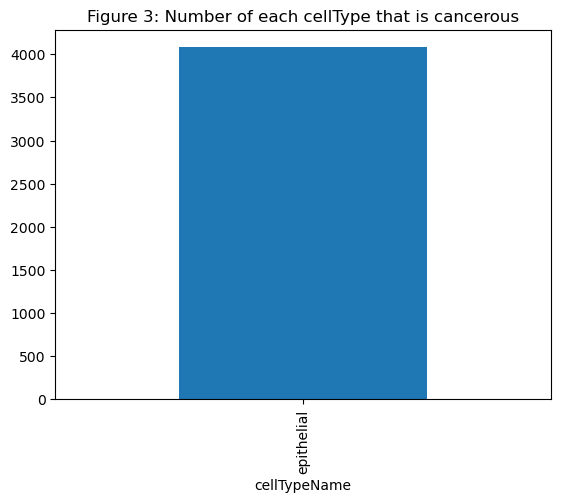

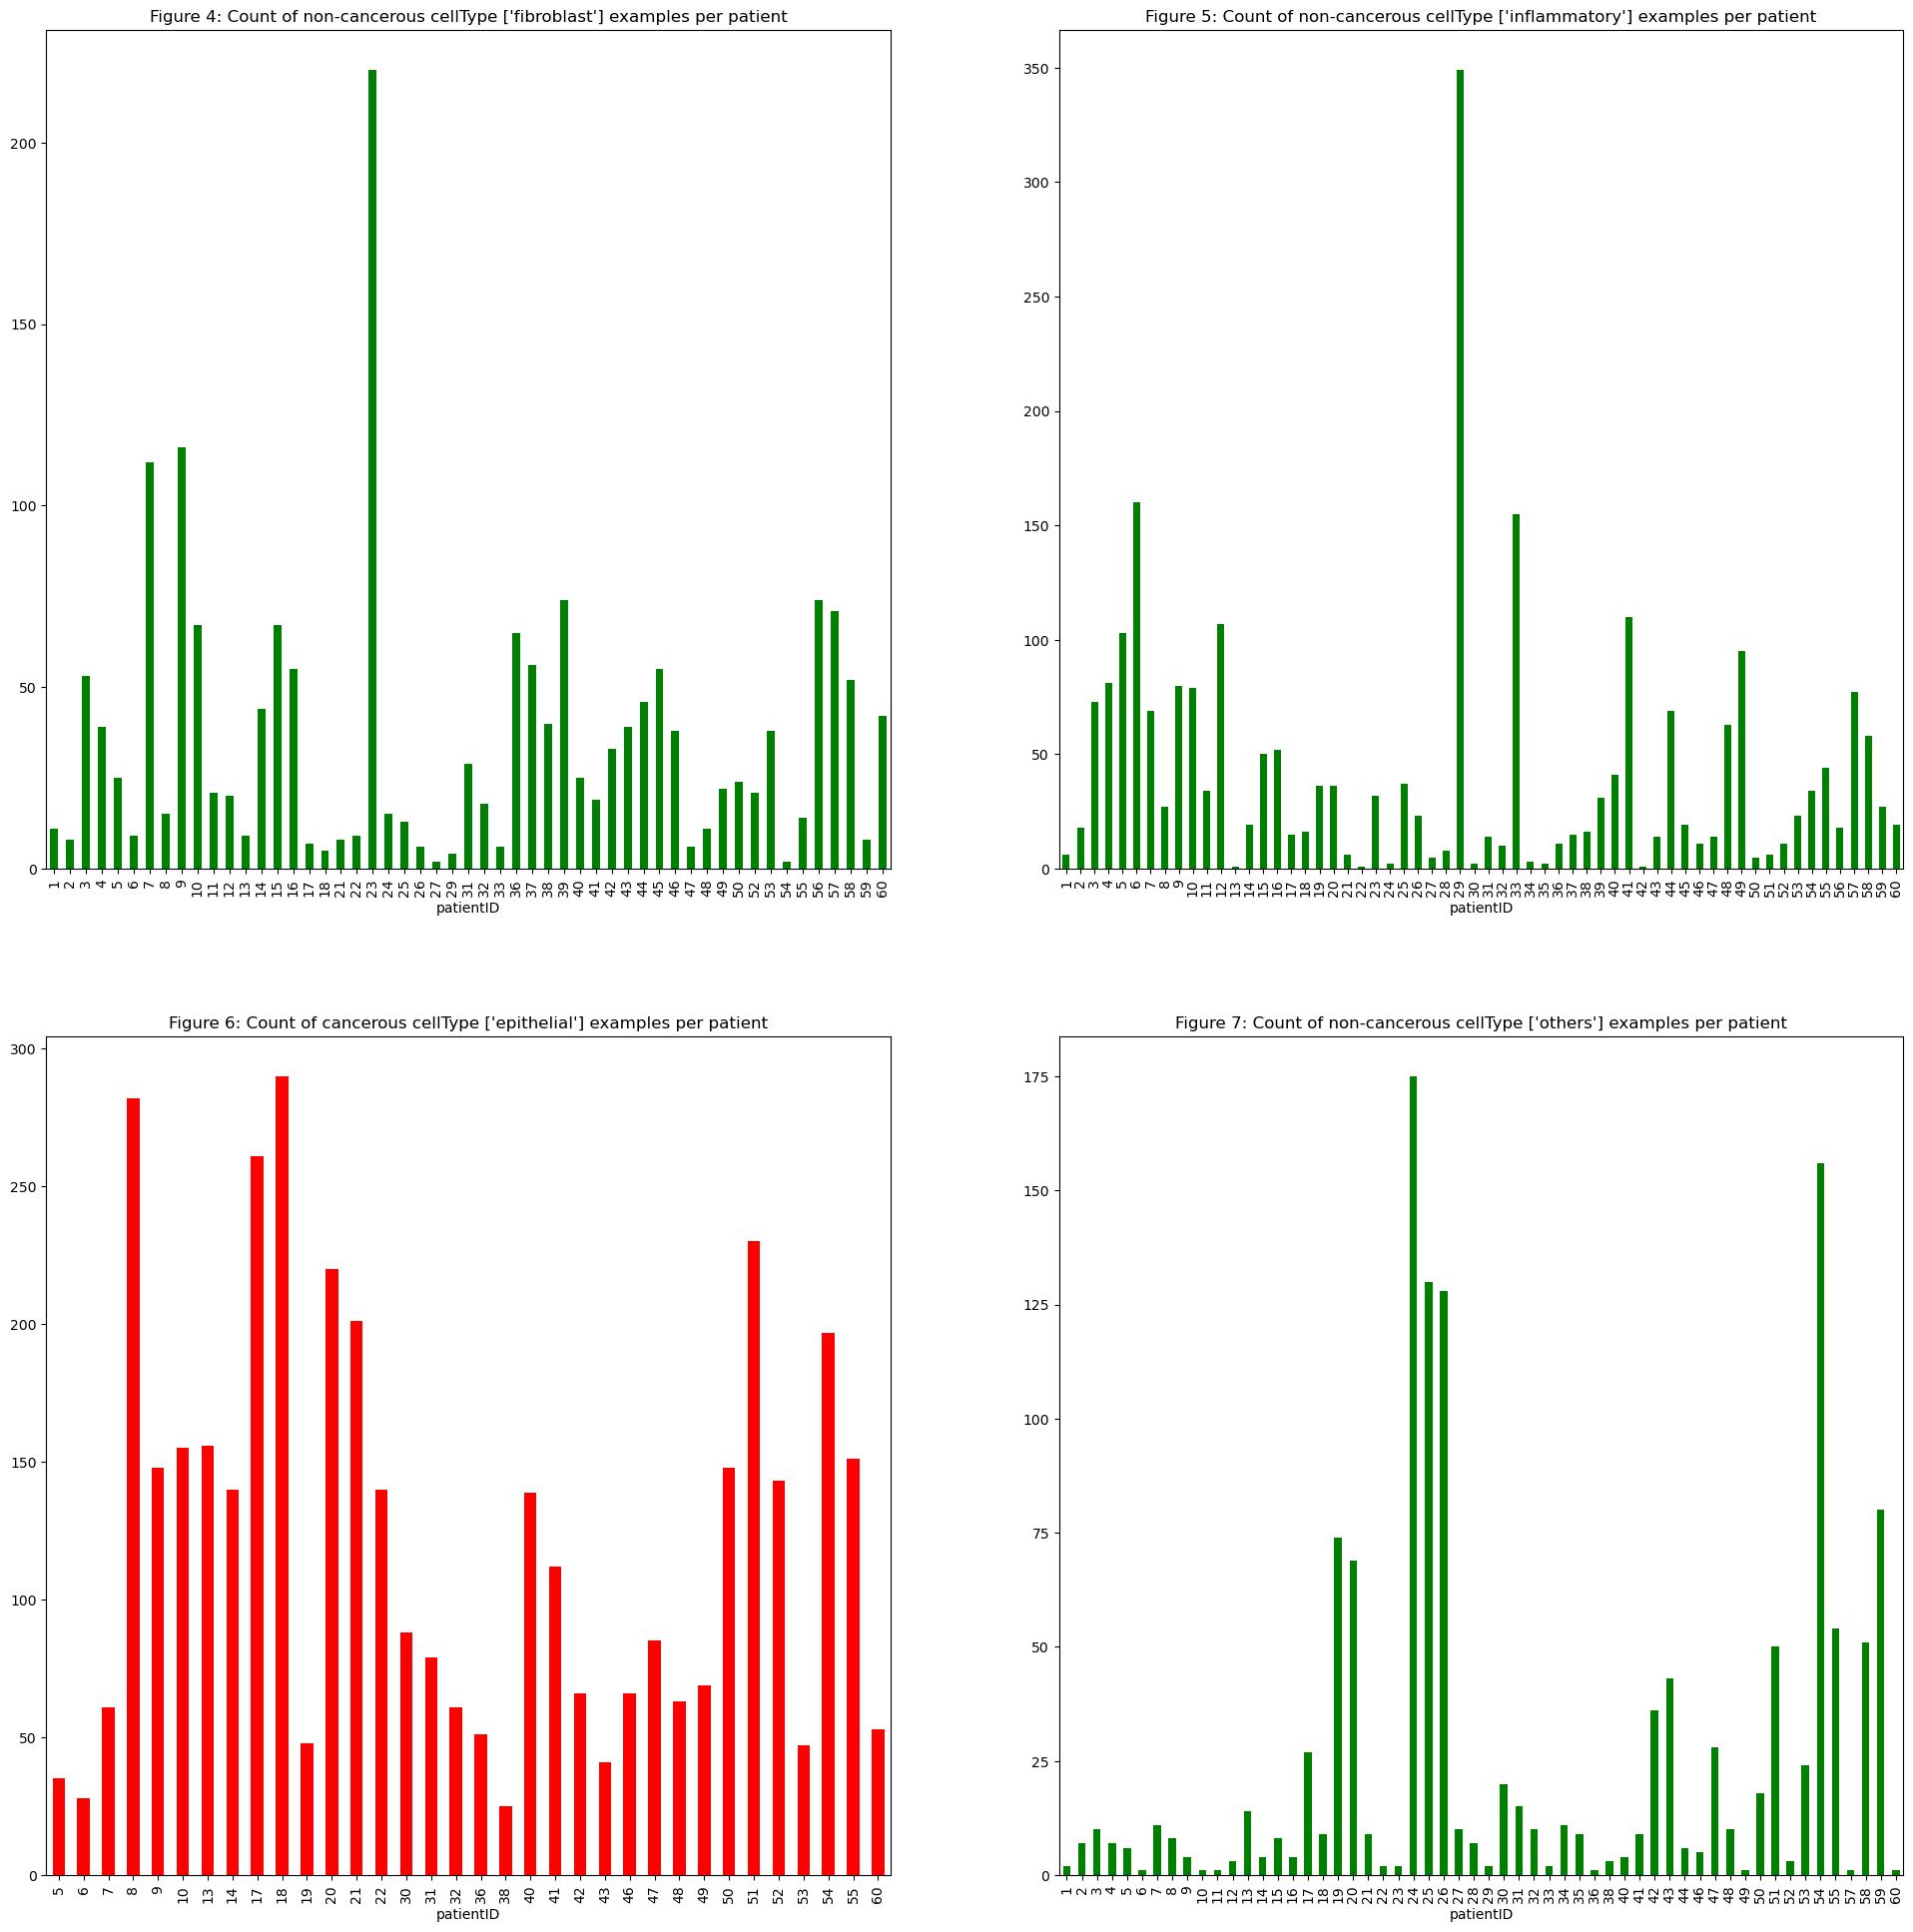

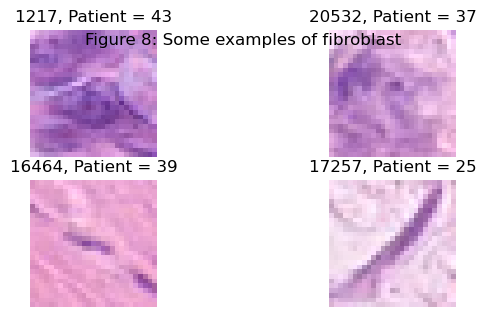

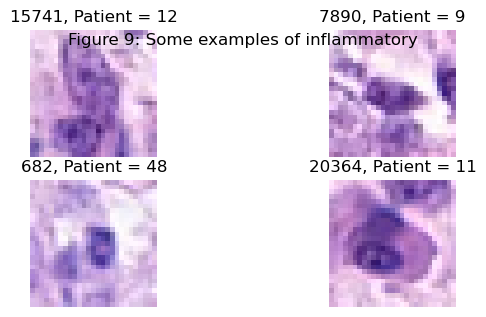

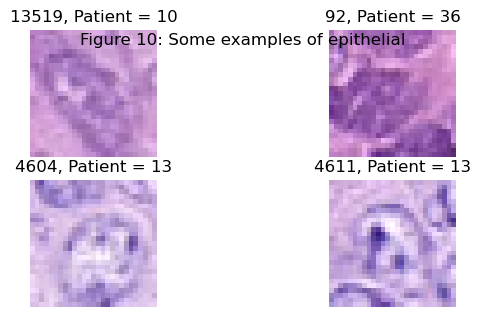

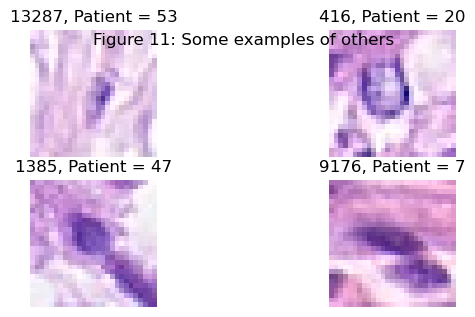

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
from skimage.feature import hog
# from skimage import data, exposure
from skimage.io import imread
from skimage.color import rgba2rgb, rgb2gray

print(data.info())
print(f'\n\nCheck if any nulls \n{data.isnull().sum()}')
print(f'\n\nSummary data statistics \n{data.describe()}')


# Below plots show count for isCancerous and cellType.
# Also the plot for which isCancerous count for each cellType 
data['isCancerous'].value_counts().plot(kind='bar', title='Figure 1: Number of cancerous versus non-cancerous examples')
plt.show()
data['cellType'].value_counts().plot(kind='bar', title='Figure 2: Number of examples for each cellType')
plt.show()
data[data['isCancerous'] == 1]['cellTypeName'].value_counts().plot(kind='bar', title='Figure 3: Number of each cellType that is cancerous')
plt.show()


# Below plots the amount of each cellType for each patientID
plt.figure(figsize=(24, 24))
figindex = 3
for i in range(0, 4):
    plt.subplot(2, 2, i + 1)
    # Get rows where cellType = i and get value count of each patientID (how many patients have that cellType)
    byCellTypeCountCancerous = data[(data['cellType'] == i) & (data['isCancerous'] == 1)]['patientID'].value_counts().sort_index()
    byCellTypeCountNotCancerous = data[(data['cellType'] == i) & (data['isCancerous'] == 0)]['patientID'].value_counts().sort_index()
    if len(byCellTypeCountCancerous) > 0:
        figindex += 1
        byCellTypeCountCancerous.plot(kind='bar', color='red', title=f'Figure {figindex}: Count of cancerous cellType {data[data['cellType'] == i]['cellTypeName'].unique()} examples per patient')
    if len(byCellTypeCountNotCancerous) > 0:
        figindex += 1
        byCellTypeCountNotCancerous.plot(kind='bar', label='isCancerous = 0', color='green', title=f'Figure {figindex}: Count of non-cancerous cellType {data[data['cellType'] == i]['cellTypeName'].unique()} examples per patient')
    
plt.show()

# Below plots example images for each cellType
import math

figIndex = 7
celltype_dict = {}
for cell in data['cellType'].unique():
    celltype_dict[cell] = data[data['cellType'] == cell]


for i in range (len(celltype_dict)):
    celltype = celltype_dict[i]
    num = 8
    col = 2
    row = math.ceil(num/col)
    plt.figure(figsize=(col * 3, row * 3))
    sample = celltype.sample(n=4)
    for j in range(len(sample)):
        image_path = sample.iloc[j]['ImageName']
        im = imread(f'./Image_classification_data/patch_images/{image_path}', as_gray=False, plugin=None)
        plt.subplot(num, col, j + 1)
        plt.title(f'{sample.iloc[j]['InstanceID']}, Patient = {sample.iloc[j]['patientID']}')
        plt.imshow(im, cmap=plt.cm.gray)
        plt.axis('off')
    plt.tight_layout(pad=0.1, h_pad=0.2, w_pad=0.0)
    figindex += 1
    plt.suptitle(f'Figure {figindex}: Some examples of {sample.iloc[1]['cellTypeName']}')
    plt.show()

In [13]:
# Data splitting

patient_dict = {}
for id  in data['patientID'].unique():
    patient_dict[id] = data[data['patientID'] == id]

patients_groupByCancerous = {}
patients_groupByNonCancerous = {}
for id, value in patient_dict.items():
    if patient_dict[id]['isCancerous'].eq(1).any():
        patients_groupByCancerous[id] = value
    else:
        patients_groupByNonCancerous[id] = value

print(f'Total number of patients is: {len(patients_groupByCancerous) + len(patients_groupByNonCancerous)}')
print(f'With {len(patients_groupByCancerous)} patients with a cancerous cell versus {len(patients_groupByNonCancerous)} patients with no cancerous cells')

# cancerousExamples = data[data['isCancerous'] == 1]
# nonCancerousExamples = data[data['isCancerous'] == 0]

# cancerousExamples_groupbypatient = {}
# for id in cancerousExamples['patientID'].unique():
#     cancerousExamples_groupbypatient[id] = cancerousExamples[cancerousExamples['patientID'] == id]

# nonCancerousExamples_groupbypatient = {}
# for id in nonCancerousExamples['patientID'].unique():
#     nonCancerousExamples_groupbypatient[id] = nonCancerousExamples[nonCancerousExamples['patientID'] == id]

TRAIN_SPLIT_PERCENT = 0.80
VALID_SPLIT_PERCENT = 0.20
TEST_SPLIT_PERCENT = 0.80
TOTAL_IMAGES = len(data)
RATIO = len(data[data['isCancerous'] == 1]) / TOTAL_IMAGES

train = pd.DataFrame(columns=data.columns)
test = pd.DataFrame(columns=data.columns)
val = pd.DataFrame(columns=data.columns)

# Pick random patients from canerous and non cancerous group 
train_split_Cancerous_keys = pd.DataFrame(list(patients_groupByCancerous.keys()), columns=['patientID']).sample(frac=TRAIN_SPLIT_PERCENT, random_state=10).reset_index(drop=True)
train_split_nonCancerous_keys = pd.DataFrame(list(patients_groupByNonCancerous.keys()), columns=['patientID']).sample(frac=TRAIN_SPLIT_PERCENT, random_state=10).reset_index(drop=True)

# From the train set pick random patients for val set
val_split_Cancerous_keys = train_split_Cancerous_keys.sample(frac=VALID_SPLIT_PERCENT, random_state=10).reset_index(drop=True)
val_split_nonCancerous_keys = train_split_nonCancerous_keys.sample(frac=VALID_SPLIT_PERCENT, random_state=10).reset_index(drop=True)


print(f'- For train set, picked {len(train_split_Cancerous_keys)} patients out of {len(patients_groupByCancerous)} patients with cancerous cells')
# print(f'They are \n {train_split_Cancerous_keys}')
print(f'- For train set, picked {len(train_split_nonCancerous_keys)} patients out of {len(patients_groupByNonCancerous)} patients with non cancerous cells')
print(f'- Therefore, there is a ratio of cancerous to total patients in train set of {len(train_split_Cancerous_keys)/(len(train_split_nonCancerous_keys) + len(train_split_Cancerous_keys))} ')
print(f'- Therefore, there is a ratio of cancerous to total patients in test set of {(len(train_split_Cancerous_keys ) - len(patients_groupByCancerous)) /(len(train_split_nonCancerous_keys) + len(train_split_Cancerous_keys) - (len(patients_groupByNonCancerous) + len(patients_groupByCancerous)))} ')

print(f'- For val set, picked {len(val_split_Cancerous_keys)} patients out of {len(train_split_Cancerous_keys)} train set patients with cancerous cells')
print(f'- For val set, picked {len(val_split_nonCancerous_keys)} patients out of {len(train_split_nonCancerous_keys)} train set patients with non cancerous cells')
print(f'- Therefore, there is a ratio of cancerous to total patient in val set of {len(val_split_Cancerous_keys)/(len(val_split_Cancerous_keys) + len(val_split_nonCancerous_keys))}')

# Now based on picks for train set place the patients in the train set otherwise in the test set.
for id, key in patients_groupByCancerous.items():
    # If key of patient is selected for train then place it in the train set else in the test set
    if train_split_Cancerous_keys['patientID'].eq(id).any():
        if val_split_Cancerous_keys['patientID'].eq(id).any():
            val = pd.concat([val, patients_groupByCancerous[id]], ignore_index=True)
        else:
            train = pd.concat([train, patients_groupByCancerous[id]], ignore_index=True)
    else:
        test = pd.concat([test, patients_groupByCancerous[id]], ignore_index=True)

for id, key in patients_groupByNonCancerous.items():
    # If key of patient is selected for train then place it in the train set else in the test set
    if train_split_nonCancerous_keys['patientID'].eq(id).any():
        if val_split_nonCancerous_keys['patientID'].eq(id).any():
            val = pd.concat([val, patients_groupByNonCancerous[id]], ignore_index=True)
        else:
            train = pd.concat([train, patients_groupByNonCancerous[id]], ignore_index=True)
    else:
        test = pd.concat([test, patients_groupByNonCancerous[id]], ignore_index=True)

print(f'- There is {len(train['patientID'].unique())} patients in the train set. The count for each cell type is:\n{train['cellType'].value_counts()}')
print(f'- There is {len(val['patientID'].unique())} patients in the val set. The count for each cell type is:\n{val['cellType'].value_counts()}')
print(f'- There is {len(test['patientID'].unique())} patients in the test set. The count for each cell type is:\n{test['cellType'].value_counts()}')
print(f'- Therefore, ratio of train to total is: {len(train)/ len(data)} versus the ratio of test to total: {len(test)/len(data)}')
print(f'- Therefore, ratio of val to train is: {len(val)/len(train)}, and the ratio of val to total is: {len(val)/len(data)}') 

print(f'- The value counts for isCancerous for train set is:\n{train['isCancerous'].value_counts()}')
print(f'- The value counts for isCancerous for val set is:\n{val['isCancerous'].value_counts()}')
print(f'- The value counts for isCancerous for test set is:\n{test['isCancerous'].value_counts()}')
print(f'- The value counts for isCancerous for whole data set is:\n{data['isCancerous'].value_counts()}')


# I could make the splitter above modular but cannot be bothered for

Total number of patients is: 60
With 34 patients with a cancerous cell versus 26 patients with no cancerous cells
- For train set, picked 27 patients out of 34 patients with cancerous cells
- For train set, picked 21 patients out of 26 patients with non cancerous cells
- Therefore, there is a ratio of cancerous to total patients in train set of 0.5625 
- Therefore, there is a ratio of cancerous to total patients in test set of 0.5833333333333334 
- For val set, picked 5 patients out of 27 train set patients with cancerous cells
- For val set, picked 4 patients out of 21 train set patients with non cancerous cells
- Therefore, there is a ratio of cancerous to total patient in val set of 0.5555555555555556
- There is 39 patients in the train set. The count for each cell type is:
cellType
2    2630
0    1454
1    1447
3     930
Name: count, dtype: int64
- There is 9 patients in the val set. The count for each cell type is:
cellType
1    679
2    553
0    222
3    158
Name: count, dtype: i

In [28]:
cell_weights = {}
maxV = max(train['cellType'].value_counts())
for i in range(0, 4):
    cell_weights[i] = maxV/len(train[train['cellType'] == i])


In [29]:
cell_weights


{0: 1.8088033012379643, 1: 1.8175535590877678, 2: 1.0, 3: 2.827956989247312}

##  4. Base Model & Performence Metric Selection
## Performance Metrics Selection 
-  **Best choice is F1 Score**. It is harmonic mean of precision and recall. Precision minimises false positives, recall minimises false negatives. Both together guide model towards making positive predictions that are truly positive and not missing positive cases. 
    - Given imbalance in target values, to evaluate if model is learning characteristics of all classes – so they can discriminately predict classes instead of guessing one prevalent class. 
      - This means less guessing every class is one prevalent class. (Precision) 
      - This means model can better discriminate characteristics of each class (Recall/Sensitivity) 

## Base Model Selection & Justification
- CNN versus MLP for cellType classification
  - The problem with MLP is the large amount of layers required to achieve performance comparable to CNN.
    - This is because MLP tries to find/learn patterns using all the pixels at once. Not considering relevance of the pixel to the problem.
       - Seeing Figure 8, 9, 10, 11 we can notice how some pixels do provide any meaningful information yet the MLP will still utilise that to identify some abstract pattern. This means it struggles to learn meaningful patterns.
    - This means more layers are required to gain/learn enough high-level abstract patterns that can meaningfully idenitfy features of the image.
    - Consequently, more training would be required.
    - This could be solved by first applying some kernel function to highlight the relevant features of the images.
      - But if this is the aim, then a CNN is better at finding and using kernal to create new features maps (convolutional layers) from which high-level abstract patterns are created. Which are used to idenitfy patterns for classification


-  CNN versus MLP for isCancerous classification
    - Given in our EDA (see Figure 3) we noted how only epithelial cells are isCancerous we could build a MLP that just learns to identify a epithelial cell.
    - However such would be naive as this (epithelial cells only cancerous) could be feature of the dataset we are using but not of the real world.
    - Therefore, it is the best idea to learn to identify characteristics of a cancerousCell.
      - But if the dataset does not offer such examples of cancerousCells that are not epithelial then any model will equate characteristics of epithelial to cancerous
    - Nonetheless, even the simple case of a model learning characteristics of epithelial, CNN will perform better as explained above (CNN vs MLP for cellType)



## Base Model Development
- We will use F1-Score for reasons as explained in above.
- Aim for a (weighted) F1-Score of ~0.79. As is achieved by the RCCNet Model.
- But we only have F1 (but not sure what type) since the keras onces are micro (overall) given that the recall and precision scores at the end  

- Using data augmentation to help with data imbalance. Data augmentation basically applies random changes to the each images before it sends them to training.
  - This does not mean the amount of actual images increases.  Just each time an example is chosen some changes are made to it.
---


In [38]:
# Data generator + Augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

OUTPUT_CLASSES_CELLTYPE = 4

# For some reason ImageDataGenerator needs classes to be strings
train['cellType'] = train['cellType'].astype(str)
val['cellType'] = val['cellType'].astype(str)


# Lets do bit of normalisation with pixel values -> faster training
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5])
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# A hyperparameter?
batch_size = 27

# For cellType classification
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train,
    directory = './Image_classification_data/patch_images/',
    x_col = 'ImageName',
    y_col = 'cellType',
    target_size=(27, 27),
    batch_size = batch_size,
    class_mode = 'categorical' # Creates onehot encoded labels
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe = val,
    directory = './Image_classification_data/patch_images/',
    x_col = 'ImageName',
    y_col = 'cellType',
    target_size=(27, 27),
    batch_size = batch_size,
    class_mode = 'categorical'
)

# For cancerous classification


train['isCancerous'] = train['isCancerous'].astype(str)
val['isCancerous'] = val['isCancerous'].astype(str)

OUTPUT_CLASSES_ISCANCEROUS = 2

train_generator_cancerous = train_datagen.flow_from_dataframe(
    dataframe = train,
    directory = './Image_classification_data/patch_images/',
    x_col = 'ImageName',
    y_col = 'isCancerous',
    target_size=(27, 27),
    batch_size = batch_size,
    class_mode = 'categorical' # Creates onehot encoded labels
)

validation_generator_cancerous = val_datagen.flow_from_dataframe(
    dataframe = val,
    directory = './Image_classification_data/patch_images/',
    x_col = 'ImageName',
    y_col = 'isCancerous',
    target_size=(27, 27),
    batch_size = batch_size,
    class_mode = 'categorical' # Creates onehot encoded labels
)

Found 6461 validated image filenames belonging to 4 classes.
Found 1612 validated image filenames belonging to 4 classes.
Found 6461 validated image filenames belonging to 2 classes.
Found 1612 validated image filenames belonging to 2 classes.


In [39]:
# Model Development

import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name, suptitle):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.suptitle(f'{suptitle}')
    plt.show()

In [26]:
import tensorflow as tf


model_VGG_1 = tf.keras.Sequential([
    # First feature extraction
    #VGG block 1
    # 32 (3x3, 3 Channels) Kernels. output => 27x27, 32 Feature Maps)
    # padding = 'same': output size = input size (see ref [1])  stride = 1 (the skip between middle of kernel) 
    # padding is adjusted to ensure same size output as input  
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    # Down sampling using max pooling. Reduces size by 2.
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    # More filters to learn more complex patterns
    # Learns patterns of the patterns in features maps of above block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(127, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Then decision maker
    # convert the ?D output tensor into a 1D Vector. if second last layer is 4x4 then (4 * 4 * 128)
    # Allows dense (fully connected) layer to make connections between activations in across many feature maps to classes?  
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_CELLTYPE),
])


model_VGG_2 = tf.keras.Sequential([
    # First feature extraction
    #VGG block 1
    # 32 (3x3, 3 Channels) Kernels. output => 27x27, 32 Feature Maps)
    # padding = 'same': output size = input size (see ref [1])  stride = 1 (the skip between middle of kernel) 
    # padding is adjusted to ensure same size output as input  
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    # Down sampling using max pooling. Reduces size by 2.
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    # More filters to learn more complex patterns
    # Learns patterns of the patterns in features maps of above block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(127, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Then decision maker
    # convert the ?D output tensor into a 1D Vector. if second last layer is 4x4 then (4 * 4 * 128)
    # Allows dense (fully connected) layer to make connections between activations in across many feature maps to classes?  
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_ISCANCEROUS),
])

/home/voyage/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-18 21:06:20.247148: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [27]:
from tensorflow.keras.metrics import Precision, Recall
# Optimizer = how to update weight
# 'adam' = (Adaptive Moment Estimation) https://www.geeksforgeeks.org/adam-optimizer/
model_VGG_1.compile(optimizer='adam',
            # IDK IF below are true for sure
            # SparseCategoricalCrossentropy expects a column with labels: 0, 1, 2, 3... then turns them into one-hot representation
            # CategoricalCrossentropy expects one-hot encoded labels: [0, 1, 0, 0]
            # from_logits means final layer doesn't have softmax activation. raw outputs. therefore keras will apply softmax inside loss func.
            # https://stackabuse.com/what-is-fromlogitstrue-in-keras-tensorflow-loss-functions/
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy', 'precision', 'recall']
              )


model_VGG_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['precision', 'recall']
              )

In [ ]:
# cellType
history_VGG_1 = model_VGG_1.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=1, class_weight=cell_weights)

/home/voyage/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


2025-05-18 21:07:54.468572: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21415680 exceeds 10% of free system memory.
2025-05-18 21:07:54.468628: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21415680 exceeds 10% of free system memory.
2025-05-18 21:07:54.483302: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19663488 exceeds 10% of free system memory.
2025-05-18 21:07:54.483355: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19663488 exceeds 10% of free system memory.
2025-05-18 21:07:54.523559: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 27713664 exceeds 10% of free system memory.


240/240 ━━━━━━━━━━━━━━━━━━━━ 30s 101ms/step - categorical_accuracy: 0.4050 - loss: 1.3204 - precision: 0.4357 - recall: 0.1532 - val_categorical_accuracy: 0.7153 - val_loss: 0.8786 - val_precision: 0.7568 - val_recall: 0.6234
Epoch 2/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - categorical_accuracy: 0.6303 - loss: 0.9266 - precision: 0.6716 - recall: 0.5590 - val_categorical_accuracy: 0.7103 - val_loss: 0.8260 - val_precision: 0.6925 - val_recall: 0.6873
Epoch 3/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - categorical_accuracy: 0.6788 - loss: 0.8081 - precision: 0.6150 - recall: 0.6892 - val_categorical_accuracy: 0.6359 - val_loss: 0.9437 - val_precision: 0.6254 - val_recall: 0.6526
Epoch 4/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - categorical_accuracy: 0.7092 - loss: 0.7403 - precision: 0.6295 - recall: 0.7628 - val_categorical_accuracy: 0.7221 - val_loss: 0.7487 - val_precision: 0.7196 - val_recall: 0.7053
Epoch 5/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - categorica

In [37]:
history_VGG_1.history

{'categorical_accuracy': [0.43120259046554565,
  0.6491255164146423,
  0.691069483757019,
  0.7136666178703308,
  0.7203219532966614,
  0.7280606627464294,
  0.72898930311203,
  0.7466336488723755,
  0.754062831401825,
  0.767528235912323,
  0.777124285697937,
  0.7992570996284485,
  0.816282331943512,
  0.8416653871536255,
  0.8582262992858887,
  0.8684414029121399,
  0.8829902410507202,
  0.9037300944328308,
  0.9159572720527649,
  0.9353041052818298,
  0.9277201890945435,
  0.9510911703109741,
  0.9529484510421753,
  0.9623897075653076,
  0.9760099053382874],
 'loss': [1.2637439966201782,
  0.8894885182380676,
  0.77560955286026,
  0.7320700287818909,
  0.7100421190261841,
  0.6911789178848267,
  0.6825883984565735,
  0.6388248205184937,
  0.6153948307037354,
  0.5876300930976868,
  0.5636570453643799,
  0.5183990597724915,
  0.47165989875793457,
  0.4118439853191376,
  0.37200599908828735,
  0.34053629636764526,
  0.30643197894096375,
  0.25957924127578735,
  0.22663457691669464,
 

In [79]:
# isCancerous
history_VGG_2 = model_VGG_2.fit(train_generator_cancerous, validation_data= validation_generator_cancerous, epochs=15, verbose=1)

Epoch 1/15


240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.6670 - precision: 0.7403 - recall: 0.0412

/home/voyage/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - loss: 0.6669 - precision: 0.7408 - recall: 0.0414 - val_loss: 0.3959 - val_precision: 0.9055 - val_recall: 0.5409
Epoch 2/15
240/240 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - loss: 0.4105 - precision: 0.8914 - recall: 0.5673 - val_loss: 0.3867 - val_precision: 0.8429 - val_recall: 0.6458
Epoch 3/15
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - loss: 0.3544 - precision: 0.9009 - recall: 0.7006 - val_loss: 0.2908 - val_precision: 0.9044 - val_recall: 0.7395
Epoch 4/15
240/240 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - loss: 0.3040 - precision: 0.9205 - recall: 0.7661 - val_loss: 0.2704 - val_precision: 0.9463 - val_recall: 0.6892
Epoch 5/15
240/240 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - loss: 0.3035 - precision: 0.9322 - recall: 0.7289 - val_loss: 0.3915 - val_precision: 0.8509 - val_recall: 0.6551
Epoch 6/15
240/240 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - loss: 0.2635 - precision: 0.9347 - recall: 0.7962 - val_loss: 0.3588 - val_precision: 0.8833 - val_recall

In [63]:
def f1_score(precision, recall):
    f1 = []
    for i in range(len(precision)):
        if precision[i] + recall[i] == 0:
            f1.append(0.0)
        else:
            f1.append(precision[i] * recall[i])
            f1[i] = f1[i] / (precision[i] + recall[i])
            f1[i] = 2 * f1[i]
            
    return f1
    

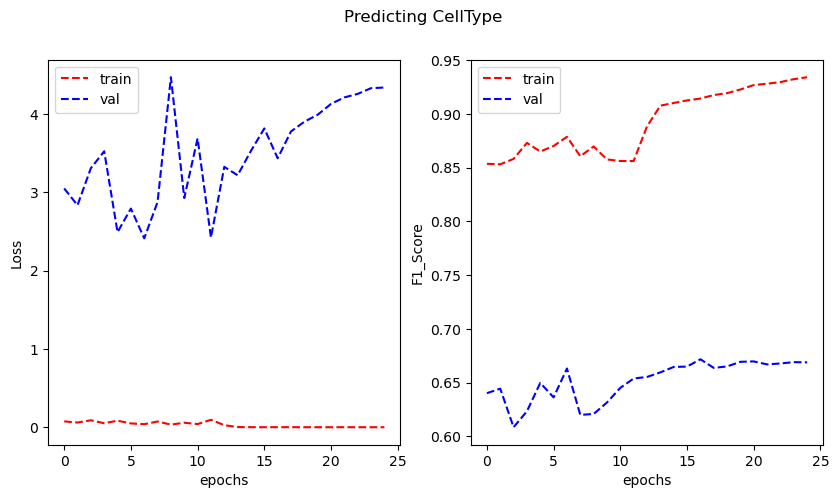

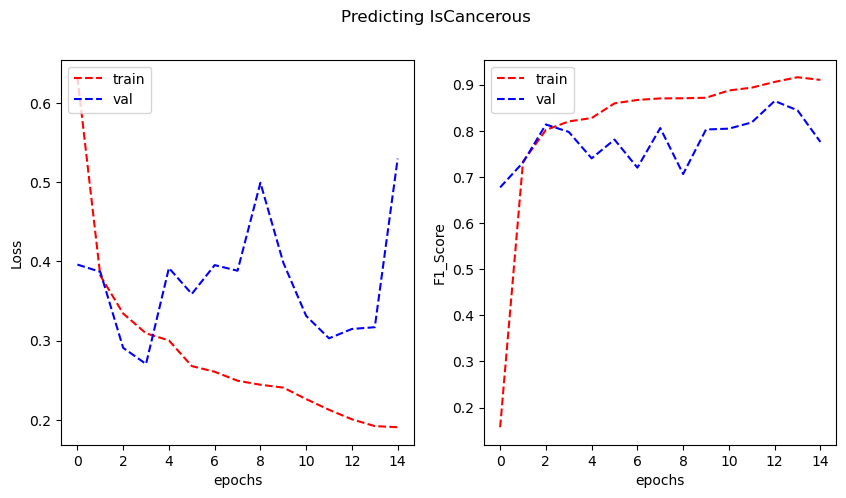

In [83]:
plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'], 
                    f1_score(history_VGG_1.history['precision'], history_VGG_1.history['recall']), f1_score(history_VGG_1.history['val_precision'], history_VGG_1.history['val_recall']), 
                    metric_name='F1_Score', suptitle="Predicting CellType")

plot_learning_curve(history_VGG_2.history['loss'], history_VGG_2.history['val_loss'], 
                    f1_score(history_VGG_2.history['precision'], history_VGG_2.history['recall']), f1_score(history_VGG_2.history['val_precision'], history_VGG_2.history['val_recall']), 
                    metric_name='F1_Score', suptitle="Predicting IsCancerous")

In [ ]:
# Appendix



# Plot of images related to each patient

# for i in range(0, 3):
#     patient = patient_dict[i]
#     num = len(patient)
#     col = 5
#     row = math.ceil(num/col)
#     plt.figure(figsize=(col * 4, row * 4))
#     for j in range(0, len(patient)):
#         # print(j)
#         image_path = patient.iloc[j]['ImageName']
#         # print(image_path)
#         im = imread(f'./Image_classification_data/patch_images/{image_path}', as_gray=True, plugin=None)
#         # print('yes')
#         plt.subplot(num, col, j + 1)
#         plt.title(f'{patient.iloc[j]['InstanceID']}, Cell = {patient.iloc[j]['cellTypeName']}')
#         plt.imshow(im, cmap=plt.cm.gray)
#         plt.axis('off')
#     plt.tight_layout(pad=0.5, h_pad=0.2, w_pad=0.2)
#     plt.show()

   